In [1]:
import pandas as pd
from tqdm import tqdm
from sqlalchemy import create_engine, inspect

import numpy as np
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.stattools import adfuller

tqdm.pandas(desc="Processing")

In [2]:
%reload_ext sql
%sql mysql://iasamori@localhost/?charset=utf8mb4
%config SqlMagic.displaylimit = 1000
%sql USE iasamori;

There's a new jupysql version available (0.11.1), you're running 0.10.9. To upgrade: pip install jupysql --upgrade
Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


Connecting to 'mysql://iasamori@localhost/?charset=utf8mb4'

Running query in 'mysql://iasamori@localhost/?charset=utf8mb4'

++
||
++
++

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R

source("../psych290_data/helper_files/psych290RcodeV1.R")

require(tidyverse)
require(RSQLite)
require(ggthemes)
require(ggpubr)
require(grid)
require(reshape2)
require(psych)
require(lm.beta)
library(caret)
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(scales) 


library(DBI)
library(RMySQL)

dbcon <- dbConnect(
  drv = MySQL(),
  host = "localhost",  # or your server address
  dbname = "iasamori",
  user = "iasamori",
  port = 3306
)

R[write to console]: Loading required package: ggthemes

R[write to console]: Loading required package: tidyverse



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Loading required package: RSQLite

R[write to console]: Loading required package: ggpubr

R[write to console]: Loading required package: psych

R[write to console]: 
Attaching package: ‘psych’


R[write to console]: The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


R[write to console]: Loading required package: lm.beta

R[write to console]: Loading required package: lattice

R[write to console]: 
Attaching package: ‘caret’


R[write to console]: The following object is masked from ‘package:purrr’:

    lift


R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following objects are masked from ‘package:psych’:

    alpha, rescale


R[write to console]: The following object is masked from ‘package:purrr’:

    discard


R[write to console]: The following object is masked from ‘package:readr’:

    col_factor




In [5]:
%%R

plot_heatmap <- function(df_clustered_melted) {
    df_clustered_melted$Var1 <- factor(df_clustered_melted$Var1, levels = unique(df_clustered_melted$Var1))
    df_clustered_melted$Var2 <- factor(df_clustered_melted$Var2, levels = unique(df_clustered_melted$Var2))
    
    p <- ggplot(df_clustered_melted, aes(x = factor(Var1), y = Var2, fill = value)) +
                scale_fill_gradient2(low = "red", mid = "white", high = "blue", 
                                     midpoint = 0, limits = c(-1, 1), name = "corr") +
                # scale_fill_gradientn(
                #     colors = c("red", "white", "white", "blue"),
                #     values = rescale(c(-0.7, -0.0, 0.0, 0.7)),
                #     limits = c(-0.7, 0.7),
                #     name = "corr (r)") +
                geom_tile() +
                labs(x="200 Topics") +
                theme_minimal() +  # Add a base theme
                theme_Publication_leaveLegend() +
                theme(
                    axis.text.y = element_text(angle = 0, hjust = 1, size = 15),
                    axis.line = element_blank(), 
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    axis.ticks.x = element_blank(),
                    axis.text.x = element_blank(),
                    axis.title.x = element_text(size = 18),
                    axis.title.y = element_blank(),
                    legend.position = "bottom"
                )
    return(p)
}

In [6]:
%%R

plot_trend_detrend <- function(trend_r_df, detrend_r_df, age, drug_name) {
    
    rownames(trend_r_df) <- trend_r_df$topic
    trend_r_df$topic <- NULL
    rownames(detrend_r_df) <- detrend_r_df$topic
    detrend_r_df$topic <- NULL
    
    row_clusters <- hclust(dist(trend_r_df))
    col_clusters <- hclust(dist(t(trend_r_df)))
    
    trend_r_df_clustered <- trend_r_df[row_clusters$order, col_clusters$order]
    trend_r_df_clustered_melted <- melt(as.matrix(trend_r_df_clustered))
    
    detrend_r_df_clustered <- detrend_r_df[row_clusters$order, col_clusters$order]
    detrend_r_df_clustered_melted <- melt(as.matrix(detrend_r_df_clustered))

    # print(rownames(trend_r_df_clustered))
    p_trend <- plot_heatmap(trend_r_df_clustered_melted)
    p_detrend <- plot_heatmap(detrend_r_df_clustered_melted)
    
    
    print(p_trend)
    print(p_detrend)
    
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_TREND.svg"), plot = p_trend, width = 3.5, height = 3.5)
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_DETREND.svg"), plot = p_detrend, width = 3.5, height = 3.5)
}

In [7]:
%%R

plot_heatmap2 <- function(df_clustered_melted) {
    df_clustered_melted$Var1 <- factor(df_clustered_melted$Var1, levels = unique(df_clustered_melted$Var1))
    df_clustered_melted$Var2 <- factor(df_clustered_melted$Var2, levels = unique(df_clustered_melted$Var2))
    
    p <- ggplot(df_clustered_melted, aes(x = factor(Var1), y = Var2, fill = value)) +
                scale_fill_gradient2(low = "red", mid = "white", high = "blue", 
                                     midpoint = 0, limits = c(-0.8, 0.8), name = "corr") +
                scale_y_discrete(limits = rev) +
                # scale_fill_gradientn(
                #     colors = c("red", "white", "white", "blue"),
                #     values = rescale(c(-0.7, -0.1, 0.1, 0.7)),
                #     limits = c(-0.7, 0.7),
                #     name = "corr (r)") +
                geom_tile() +
                labs(x="Selected Topics", y="Age") +
                theme_minimal() +  # Add a base theme
                theme_Publication_leaveLegend() +
                theme(
                    axis.text.y = element_text(angle = 0, hjust = 1, size = 15),
                    axis.text.x = element_text(angle = 90),
                    axis.line = element_blank(), 
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    axis.ticks.x = element_blank(),
                    # axis.text.x = element_blank(),
                    axis.title.x = element_text(size = 18),
                    axis.title.y = element_text(size = 18),
                    # axis.title.y = element_blank(),
                    legend.position = "bottom"
                )
    return(p)
}

In [8]:
%%R

plot_trend_detrend2 <- function(trend_r_df, detrend_r_df, age, drug_name, labels_df) {
    rownames(labels_df) <- labels_df$topic
    labels_df$topic <- NULL

    rownames(trend_r_df) <- trend_r_df$topic
    trend_r_df$topic <- NULL

    rownames(detrend_r_df) <- detrend_r_df$topic
    detrend_r_df$topic <- NULL
    
    row_clusters_trend <- hclust(dist(trend_r_df))
    row_clusters_detrend <- hclust(dist(labels_df))
    # row_clusters_detrend <- hclust(dist(detrend_r_df))

    # trend_r_df_clustered <- trend_r_df[row_clusters_trend$order, ]
    trend_r_df_clustered <- trend_r_df[row_clusters_detrend$order, ]
    trend_r_df_clustered_melted <- melt(as.matrix(trend_r_df_clustered))

    
    detrend_r_df_clustered <- detrend_r_df[row_clusters_detrend$order, ]
    detrend_r_df_clustered_melted <- melt(as.matrix(detrend_r_df_clustered))

    p_trend <- plot_heatmap2(trend_r_df_clustered_melted)
    p_detrend <- plot_heatmap2(detrend_r_df_clustered_melted)
    
    print(p_trend)
    print(p_detrend)
    
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_TREND.svg"), plot = p_trend, width = 4.5, height = 4.0)
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_DETREND.svg"), plot = p_detrend, width = 4.5, height = 4.0)
}

In [9]:
drug_names = list(tpc_age_range["drug_name"].unique())
print(drug_names)

# drug_name = "nat_opioid"
for drug_name in drug_names:
    print("******",drug_name,"******")
    corr_topics = get_corr_topics(drug_name)
    
    drug_df = tpc_age_range[tpc_age_range["drug_name"]==drug_name]
    drug_df = drug_df[drug_df["topic"].isin(corr_topics)]
    
    drug_trend_df = get_trend_df(drug_df, "trend_r")
    drug_detrend_df = get_trend_df(drug_df, "detrend_r")
    
    age = "ALL"
    
    %R -i drug_trend_df -i drug_detrend_df -i age -i drug_name
    %R plot_trend_detrend2(drug_trend_df, drug_detrend_df, age, drug_name)

NameError: name 'tpc_age_range' is not defined

# ALL AGES

In [13]:
tpc_all_ages = pd.read_csv("./tpc_age_all_corr.csv")
# tpc_all_ages = pd.read_csv("./tpc_age_range_corr_AUTO.csv")
tpc_all_ages

,topic,drug_name,mean_r,trend_r,detrend_r,lead,adf_pvalue,pw_r
0,0,heroin,-0.432021,-0.522721,-0.341321,0,8.991104e-01,-0.208908
1,0,nat_opioid,-0.374593,-0.498043,-0.251143,3,1.378577e-02,-0.190204
2,0,methadone,0.441878,0.459731,0.424024,1,8.991104e-01,0.560795
3,0,syn_opioid,-0.301046,-0.353062,-0.249030,3,1.378577e-02,-0.395366
4,0,cocaine,-0.224596,-0.173549,-0.275642,3,1.378577e-02,-0.397459
...,...,...,...,...,...,...,...,...
1395,199,methadone,-0.281222,-0.378563,-0.183881,6,4.797703e-10,-0.293999
1396,199,syn_opioid,-0.243248,-0.369877,-0.116620,3,1.180586e-07,-0.150846
1397,199,cocaine,-0.201226,-0.434900,0.032449,6,1.180586e-07,-0.147857
1398,199,unspecified,-0.438384,-0.460865,-0.415902,3,4.797703e-10,-0.534618


In [14]:
trend_r_df = tpc_all_ages.pivot(index="topic", columns="drug_name", values="trend_r")
trend_r_df = trend_r_df.reset_index()
# trend_r_df = trend_r_df[["topic", "heroin", "methadone", "nat_opioid", "syn_opioid"]]

trend_r_df

drug_name,topic,cannabis,cocaine,heroin,methadone,nat_opioid,syn_opioid,unspecified
0,0,-0.330314,-0.173549,-0.522721,0.459731,-0.498043,-0.353062,-0.494568
1,1,0.191415,-0.356662,0.090230,-0.457273,-0.330776,-0.386151,-0.256145
2,2,0.357950,0.349887,0.194773,-0.362760,0.423993,0.445533,0.415453
3,3,-0.538904,-0.373973,-0.687844,-0.332262,-0.638923,-0.499100,-0.466691
4,4,-0.334407,0.241791,-0.102601,-0.193511,-0.229021,-0.205669,-0.094375
...,...,...,...,...,...,...,...,...
195,195,-0.247884,0.230570,0.105406,0.208597,0.171026,0.179826,0.134942
196,196,-0.202914,-0.216311,-0.266164,-0.297132,-0.366389,-0.275525,-0.388558
197,197,-0.142660,-0.367978,-0.146645,-0.313551,-0.160054,-0.334316,0.002413
198,198,0.459877,0.384476,0.820876,0.332115,0.737340,0.589200,0.790400


In [15]:
detrend_r_df = tpc_all_ages.pivot(index="topic", columns="drug_name", values="pw_r")
detrend_r_df = detrend_r_df.reset_index()
# detrend_r_df = detrend_r_df[["topic", "heroin", "methadone", "nat_opioid", "syn_opioid"]]

detrend_r_df

drug_name,topic,cannabis,cocaine,heroin,methadone,nat_opioid,syn_opioid,unspecified
0,0,-0.119814,-0.397459,-0.208908,0.560795,-0.190204,-0.395366,-0.138053
1,1,0.347356,-0.118219,0.212344,-0.444849,-0.325275,-0.180100,0.060890
2,2,0.136188,0.268260,0.261617,-0.355088,0.148495,0.277897,0.329665
3,3,-0.151145,0.114267,-0.091092,-0.181802,0.122970,-0.094103,-0.336904
4,4,-0.326712,0.422253,-0.223223,0.129307,-0.239862,-0.305476,-0.315501
...,...,...,...,...,...,...,...,...
195,195,-0.295201,0.435793,0.236692,0.234220,0.194302,0.324782,0.221415
196,196,-0.125606,-0.392529,-0.040965,-0.356369,0.122091,-0.356533,-0.303462
197,197,-0.360616,-0.163968,-0.296535,-0.425469,-0.090634,-0.286852,-0.116099
198,198,0.359752,0.247454,0.120691,0.355964,0.024202,0.321440,0.285982


In [16]:
trend_r_df[trend_r_df > 0].min()

drug_name
topic          1.000000
cannabis       0.075421
cocaine        0.007808
heroin         0.012212
methadone      0.078993
nat_opioid     0.063285
syn_opioid     0.005747
unspecified    0.002413
dtype: float64

In [17]:
detrend_r_df[detrend_r_df > 0].min()

drug_name
topic          1.000000
cannabis       0.000787
cocaine        0.008463
heroin         0.002482
methadone      0.017685
nat_opioid     0.000944
syn_opioid     0.003094
unspecified    0.000488
dtype: float64

In [150]:
len(detrend_r_df[detrend_r_df > 0].dropna(axis=0))

26

In [456]:
detrend_r_df[detrend_r_df > 0].min().min()

0.0050631905664249

In [455]:
trend_r_df[trend_r_df > 0].min().min()

0.0024125556498878

In [18]:
%%R

plot_trend_detrend <- function(trend_r_df, detrend_r_df, age, drug_name) {
    
    rownames(trend_r_df) <- trend_r_df$topic
    trend_r_df$topic <- NULL
    rownames(detrend_r_df) <- detrend_r_df$topic
    detrend_r_df$topic <- NULL
    
    row_clusters <- hclust(dist(trend_r_df), method = "single")
    col_clusters <- hclust(dist(t(trend_r_df)))
    
    trend_r_df_clustered <- trend_r_df[rev(row_clusters$order), col_clusters$order]
    trend_r_df_clustered_melted <- melt(as.matrix(trend_r_df_clustered))
    
    detrend_r_df_clustered <- detrend_r_df[rev(row_clusters$order), col_clusters$order]
    detrend_r_df_clustered_melted <- melt(as.matrix(detrend_r_df_clustered))

    # print(rownames(trend_r_df_clustered))
    p_trend <- plot_heatmap(trend_r_df_clustered_melted)
    p_detrend <- plot_heatmap(detrend_r_df_clustered_melted)
    
    
    print(p_trend)
    print(p_detrend)
    
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_TREND.svg"), plot = p_trend, width = 3.5, height = 3.5)
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_DETREND.svg"), plot = p_detrend, width = 3.5, height = 3.5)
}

/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


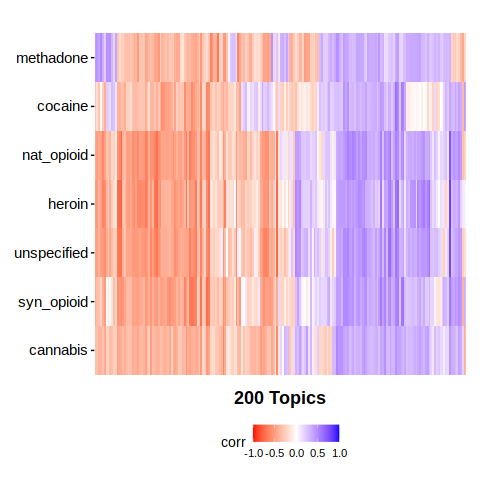

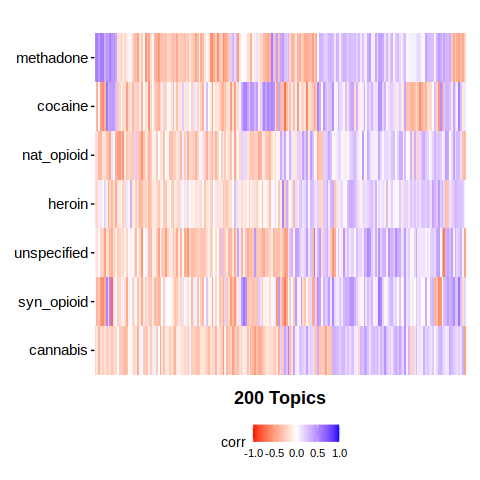

'./v2_figures/heatmap_tpc7_ageALL_ALL_DETREND.svg'


In [19]:
age = "ALL"; drug_name = "ALL"

%R -i trend_r_df -i detrend_r_df -i age -i drug_name
%R plot_trend_detrend(trend_r_df, detrend_r_df, age, drug_name)

## detrend heatmap mini

In [229]:
# %%R

# plot_heatmap_mini <- function(df_clustered_melted) {
#     df_clustered_melted$Var1 <- factor(df_clustered_melted$Var1, levels = unique(df_clustered_melted$Var1))
#     df_clustered_melted$Var2 <- factor(df_clustered_melted$Var2, levels = unique(df_clustered_melted$Var2))

#     # print(df_clustered_melted)
#     p <- ggplot(df_clustered_melted, aes(x = Var2, y = factor(Var1), fill = value)) +
#                 scale_fill_gradient2(low = "red", mid = "white", high = "blue", 
#                                      midpoint = 0, limits = c(-1, 1), name = "corr") +
#                 geom_tile() +
#                 labs(y="Topic") +
#                 theme_minimal() +  # Add a base theme
#                 theme_Publication_leaveLegend() +
#                 theme(
#                     axis.text.x = element_text(angle = 90, hjust = 1, size = 15),
#                     axis.line = element_blank(), 
#                     panel.grid.major = element_blank(),
#                     panel.grid.minor = element_blank(),
#                     panel.background = element_blank(),
#                     axis.ticks.y = element_blank(),
#                     axis.text.y = element_blank(),
#                     axis.title.y = element_text(size = 18),
#                     axis.title.x = element_blank()
#                 )
#     return(p)
# }

In [20]:
%%R

plot_heatmap_mini <- function(df_clustered_melted) {
    df_clustered_melted$Var1 <- factor(df_clustered_melted$Var1, levels = unique(df_clustered_melted$Var1))
    df_clustered_melted$Var2 <- factor(df_clustered_melted$Var2, levels = unique(df_clustered_melted$Var2))

    # print(df_clustered_melted)
    p <- ggplot(df_clustered_melted, aes(x = factor(Var1), y = Var2, fill = value)) +
                scale_fill_gradient2(low = "red", mid = "white", high = "blue", 
                                     midpoint = 0, limits = c(-1, 1), name = "corr") +
                geom_tile() +
                labs(x="75 Topics") +
                theme_minimal() +  # Add a base theme
                theme_Publication_leaveLegend() +
                theme(
                    axis.text.y = element_text(angle = 0, hjust = 1, size = 15),
                    axis.line = element_blank(), 
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    axis.ticks.x = element_blank(),
                    axis.text.x = element_blank(),
                    axis.title.x = element_text(size = 18),
                    axis.title.y = element_blank(),
                    legend.position = "bottom"
                )
    return(p)
}

In [21]:
%%R

plot_detrend_mini <- function(trend_r_df, detrend_r_df, age, drug_name) {
    
    rownames(trend_r_df) <- trend_r_df$topic
    trend_r_df$topic <- NULL
    rownames(detrend_r_df) <- detrend_r_df$topic
    detrend_r_df$topic <- NULL
    
    row_clusters <- hclust(dist(trend_r_df), method = "single")
    col_clusters <- hclust(dist(t(trend_r_df)))

    trend_r_df_clustered <- trend_r_df[rev(row_clusters$order), col_clusters$order]
    trend_r_df_clustered <- tail(trend_r_df_clustered, 75)
    print(rownames(tail(trend_r_df_clustered, 75)))
    trend_r_df_clustered_melted <- melt(as.matrix(trend_r_df_clustered))

    detrend_r_df_clustered <- detrend_r_df[rev(row_clusters$order), col_clusters$order]
    detrend_r_df_clustered <- tail(detrend_r_df_clustered, 75)
    detrend_r_df_clustered_melted <- melt(as.matrix(detrend_r_df_clustered))

    p_trend_mini <- plot_heatmap_mini(trend_r_df_clustered_melted)
    p_detrend_mini <- plot_heatmap_mini(detrend_r_df_clustered_melted)
    
    print(p_trend_mini)
    print(p_detrend_mini)
    
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_TREND_mini.svg"), plot = p_trend_mini, width = 2.5, height = 3.5)
    ggsave(paste0("./v2_figures/heatmap_tpc7_age",age, "_",drug_name,"_DETREND_mini.svg"), plot = p_detrend_mini, width = 2.5, height = 3.5)
}

 [1] "15"  "131" "41"  "136" "80"  "58"  "11"  "186" "164" "123" "98"  "189"
[13] "178" "76"  "182" "111" "68"  "36"  "66"  "146" "151" "160" "60"  "50" 
[25] "77"  "190" "45"  "110" "180" "166" "35"  "75"  "114" "141" "103" "93" 
[37] "102" "28"  "5"   "91"  "194" "130" "21"  "101" "65"  "57"  "54"  "107"
[49] "157" "85"  "37"  "177" "152" "119" "42"  "170" "191" "192" "59"  "48" 
[61] "25"  "115" "129" "83"  "175" "32"  "198" "128" "12"  "100" "84"  "8"  
[73] "2"   "1"   "154"


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


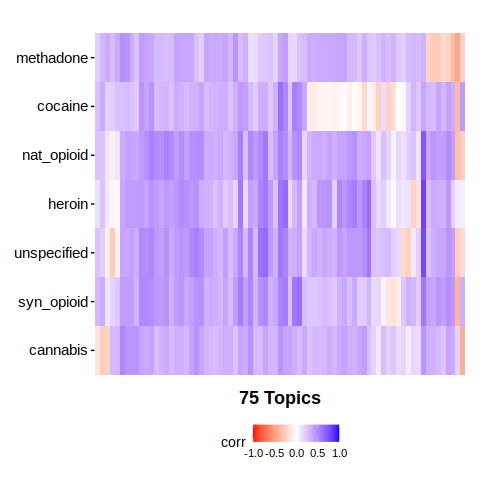

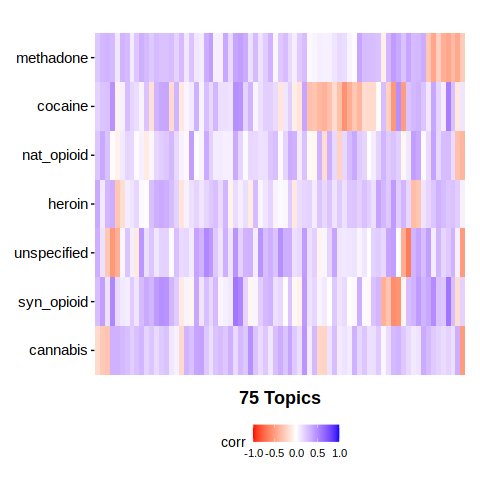

'./v2_figures/heatmap_tpc7_ageALL_ALL_DETREND_min...


In [22]:
age = "ALL"; drug_name = "ALL"

%R -i trend_r_df -i detrend_r_df -i age -i drug_name
%R plot_detrend_mini(trend_r_df, detrend_r_df, age, drug_name)

# AGE RANGE

In [23]:
def get_trend_df(df, trend_type):
    df_t = df.pivot(index="topic", columns="age", values=trend_type)
    df_t = df_t.reset_index()
    return df_t

In [24]:
def get_corr_topics(drug_name):
    tpc_all_ages = pd.read_csv("./tpc_age_all_corr.csv")
    tmp = tpc_all_ages[tpc_all_ages["drug_name"]==drug_name]
    tmp = tmp[(tmp["trend_r"]>0.4) & (tmp["detrend_r"]>0.2)]
    return tmp["topic"].to_list()

In [25]:
get_corr_topics("syn_opioid")

[8,
 11,
 28,
 35,
 58,
 68,
 75,
 76,
 84,
 100,
 103,
 123,
 128,
 141,
 151,
 166,
 178,
 180,
 182,
 189,
 198]

In [22]:
get_corr_topics("syn_opioid")

[8,
 11,
 28,
 35,
 58,
 68,
 75,
 76,
 84,
 100,
 103,
 123,
 128,
 141,
 151,
 166,
 178,
 180,
 182,
 189,
 198]

In [39]:
tpc_age_range = pd.read_csv("./tpc_age_range_corr.csv")
# tpc_age_range = pd.read_csv("./tpc_age_range_corr_OTHER_OUTCOMES.csv")
# tpc_age_range = pd.read_csv("./tpc_age_range_corr_AUTO2.csv")

tpc_age_range["age"] = tpc_age_range["age"].str.replace("_","-")
tpc_age_range

,topic,drug_age_range_list,drug_name,age,mean_r,trend_r,detrend_r,lead,adf_pvalue,pw_r
0,0,cocaine_20_24_norm,cocaine,20-24,0.040617,-0.148660,0.229895,0,1.378577e-02,-0.132294
1,0,cocaine_25_29_norm,cocaine,25-29,-0.032612,-0.258565,0.193342,4,1.378577e-02,-0.151559
2,0,cocaine_30_34_norm,cocaine,30-34,0.141047,-0.001690,0.283784,4,1.378577e-02,-0.293356
3,0,cocaine_35_39_norm,cocaine,35-39,0.120500,0.041419,0.199580,1,1.378577e-02,-0.176348
4,0,cocaine_40_44_norm,cocaine,40-44,0.119353,0.063493,0.175212,2,1.378577e-02,0.116480
...,...,...,...,...,...,...,...,...,...,...
8995,199,syn_opioid_45_49_norm,syn_opioid,45-49,-0.079536,-0.178419,0.019347,0,1.180586e-07,0.172430
8996,199,syn_opioid_50_54_norm,syn_opioid,50-54,0.068901,-0.116174,0.253975,1,1.180586e-07,-0.471795
8997,199,syn_opioid_55_59_norm,syn_opioid,55-59,-0.061909,-0.183338,0.059520,1,1.180586e-07,-0.113408
8998,199,syn_opioid_60_64_norm,syn_opioid,60-64,0.086611,-0.092600,0.265821,1,1.180586e-07,0.112497


In [36]:
corr_topics = get_corr_topics("syn_opioid")
    
drug_df = tpc_age_range[tpc_age_range["drug_name"]=="syn_opioid"]
drug_df = drug_df[drug_df["topic"].isin(corr_topics)]

labels_df = get_trend_df(tmp_df, "detrend_r")
drug_trend_df = get_trend_df(drug_df, "detrend_r")
drug_detrend_df = get_trend_df(drug_df, "pw_r")

In [126]:
drug_detrend_df = drug_detrend_df.drop(['topic'], axis=1)

In [38]:
drug_detrend_df.abs().mean(axis=0).round(2)

age
topic    108.67
15-19      0.19
20-24      0.26
25-29      0.26
30-34      0.37
35-39      0.37
40-44      0.31
45-49      0.15
50-54      0.22
55-59      0.21
60-64      0.31
65-69      0.16
dtype: float64

In [35]:
# tmp_df = pd.read_csv("./tpc_age_range_corr.csv")
tmp_df = pd.read_csv("./tpc_age_range_corr_AUTO2.csv")
tmp_df["age"] = tmp_df["age"].str.replace("_","-")
tmp_df = tmp_df[tmp_df["drug_name"]=="syn_opioid"]
tmp_df = tmp_df[tmp_df["topic"].isin(corr_topics)]

In [30]:
labels_df

NameError: name 'labels_df' is not defined

In [70]:
labels_df.mean(axis=0)

age
topic    108.666667
15-19      0.211519
20-24      0.310600
25-29      0.368827
30-34      0.379280
35-39      0.397205
40-44      0.289913
45-49      0.185455
50-54      0.263845
55-59      0.214546
60-64      0.304263
65-69      0.201816
dtype: float64

['cocaine', 'heroin', 'methadone', 'nat_opioid', 'syn_opioid']
****** cocaine ******


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


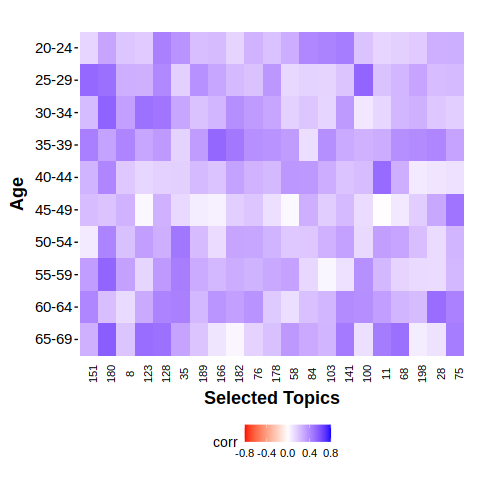

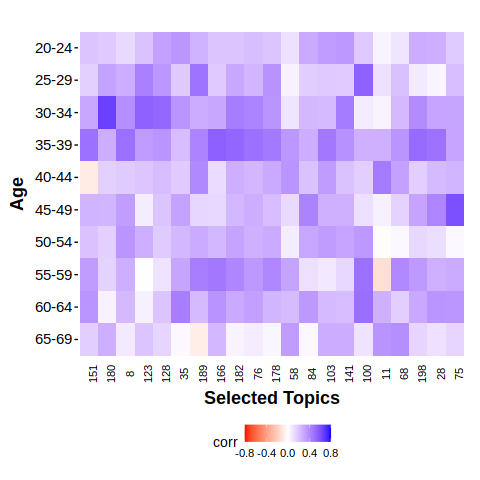

****** heroin ******


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


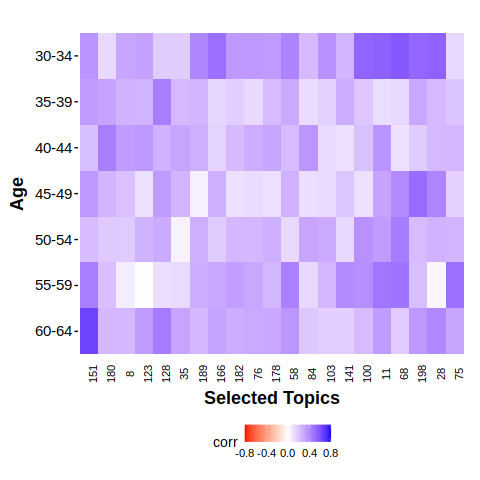

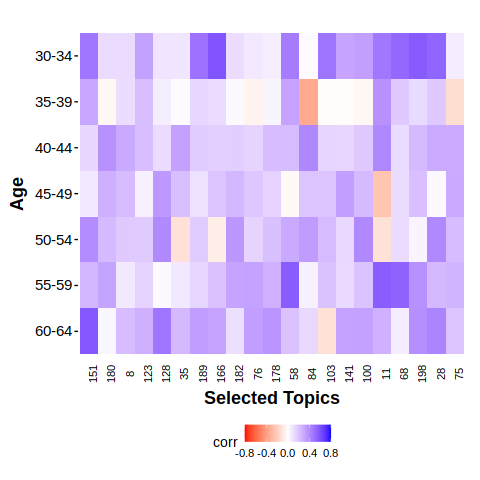

****** methadone ******


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


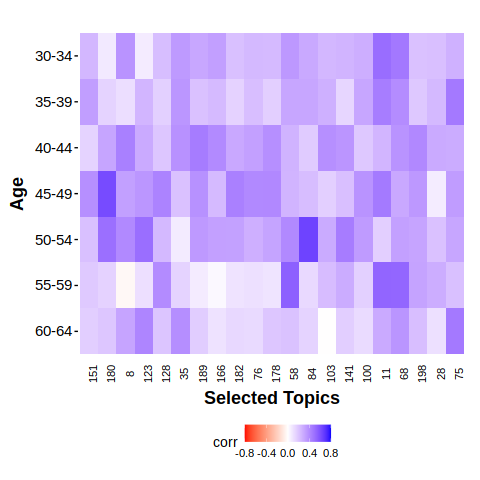

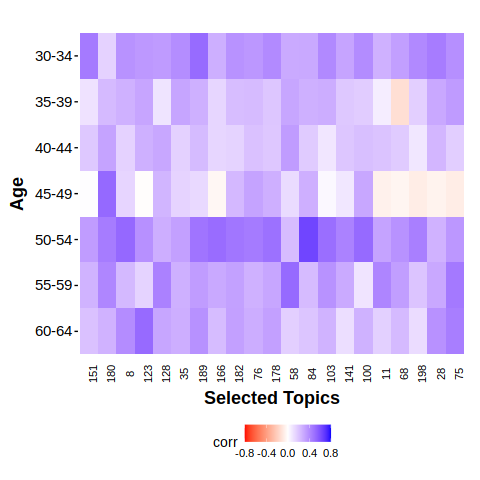

****** nat_opioid ******


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


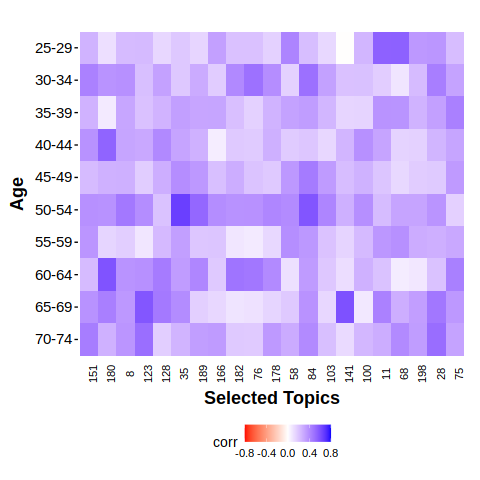

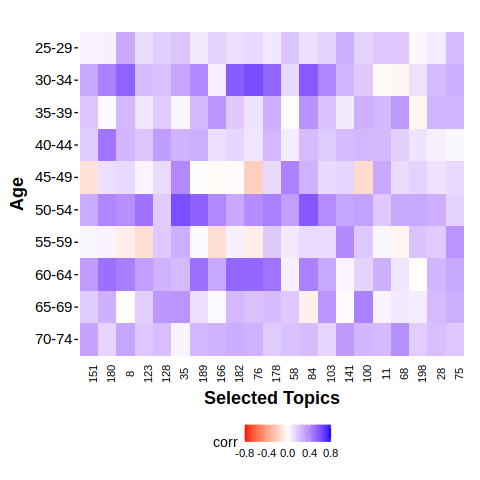

****** syn_opioid ******


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


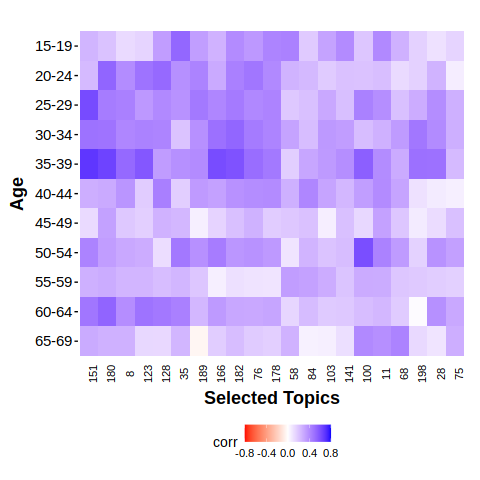

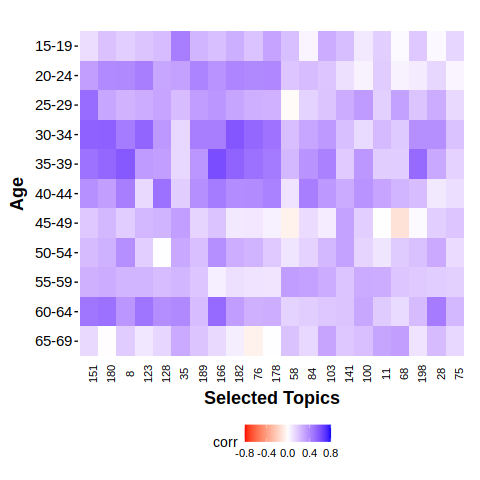

In [37]:
drug_names = list(tpc_age_range["drug_name"].unique())
print(drug_names)

# drug_name = "nat_opioid"
for drug_name in drug_names:
    print("******",drug_name,"******")
    corr_topics = get_corr_topics("syn_opioid")
    
    drug_df = tpc_age_range[tpc_age_range["drug_name"]==drug_name]
    drug_df = drug_df[drug_df["topic"].isin(corr_topics)]

    labels_df = get_trend_df(tmp_df, "detrend_r")
    drug_trend_df = get_trend_df(drug_df, "detrend_r")
    drug_detrend_df = get_trend_df(drug_df, "pw_r")
    
    age = "ALL2"
    
    %R -i drug_trend_df -i drug_detrend_df -i age -i drug_name -i labels_df
    %R plot_trend_detrend2(drug_trend_df, drug_detrend_df, age, drug_name, labels_df)

# Lead Distribution

## version 1

In [302]:
tpc_all_ages

,topic,drug_name,mean_r,trend_r,detrend_r,lead
0,0,heroin,0.048635,-0.410950,0.508219,1
1,0,nat_opioid,-0.010098,-0.338834,0.318639,2
2,0,methadone,0.441878,0.459731,0.424024,1
3,0,syn_opioid,0.116641,-0.102706,0.335989,1
4,0,cocaine,0.209925,0.153460,0.266390,1
...,...,...,...,...,...,...
1395,199,methadone,0.136702,0.044459,0.228945,4
1396,199,syn_opioid,0.033535,-0.195822,0.262891,1
1397,199,cocaine,0.079945,-0.031320,0.191211,1
1398,199,unspecified,0.059271,-0.184158,0.302700,1


In [362]:
tpc_all_ages = pd.read_csv("../data/correlations/tpc_age_all_corr.csv")
lead_df = tpc_all_ages[["drug_name","lead"]]
lead_df = lead_df[lead_df["drug_name"].isin(["syn_opioid","heroin", "nat_opioid"])]
lead_df

,drug_name,lead
0,heroin,0
1,nat_opioid,3
3,syn_opioid,3
7,heroin,0
8,nat_opioid,6
...,...,...
1387,nat_opioid,0
1389,syn_opioid,3
1393,heroin,1
1394,nat_opioid,2


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


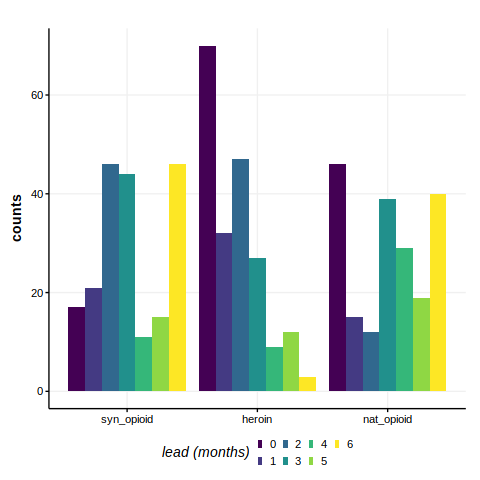

In [363]:
%%R -i lead_df

lead_df$drug_name <- factor(lead_df$drug_name, levels = c("syn_opioid", "heroin", "nat_opioid"))

# Assuming your dataframe is named lead_df
plot_data <- lead_df %>%
  group_by(drug_name, lead) %>%
  summarise(count = n(), .groups = 'drop') %>%
  mutate(lead = factor(lead, levels = 0:6))

p <- ggplot(plot_data, aes(x = drug_name, y = count, fill = lead)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis_d() +
  theme_minimal() +
  labs(x = NULL, y = "counts", fill = "lead (months)") +
  theme_Publication()
  # theme(axis.text.x = element_text(angle = 0, hjust = 1))

ggsave("./v2_figures/lead_barplot.svg", plot = p, width = 3.5, height = 2.5)
p

## version 2

In [489]:
tpc_all_ages = pd.read_csv("../data/correlations/tpc_age_all_corr.csv")
lead_dict = {}

drug_names = ["syn_opioid", "heroin", "nat_opioid"]
# drug_names = ["methadone", "cocaine", "cannabis"]

for drug_name in drug_names:
    
    tmp = tpc_all_ages[tpc_all_ages["drug_name"]==drug_name]
    tmp = tmp[tmp["trend_r"]>0]
    tmp = tmp["lead"].value_counts().sort_index()
    lead_dict[drug_name] = dict(tmp)

lead_df = pd.DataFrame(lead_dict)
lead_df

,syn_opioid,heroin,nat_opioid
0,8,29,17
1,11,17,9
2,23,16,3
3,24,15,22
4,4,3,13
5,6,8,8
6,14,2,19


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


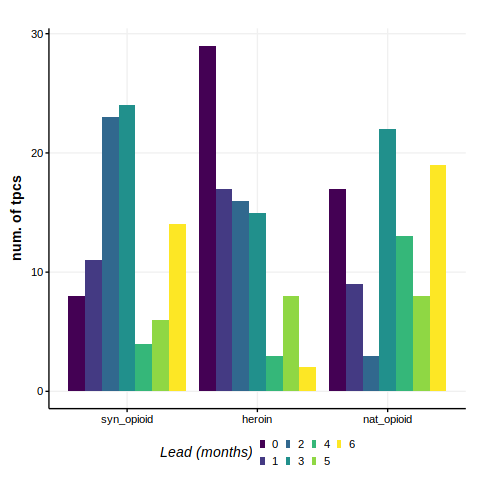

In [490]:
%%R -i lead_df


lead_df$lead <- 0:(nrow(lead_df)-1)

# Reshape to long format
plot_data <- lead_df %>%
  pivot_longer(
    cols = c(syn_opioid, heroin, nat_opioid),
    # cols = c(methadone, cocaine, cannabis),
    names_to = "drug_name",
    values_to = "count"
  ) %>%
  mutate(
    lead = factor(lead, levels = 0:6),
    drug_name = factor(drug_name, levels = c("syn_opioid", "heroin", "nat_opioid"))
    # drug_name = factor(drug_name, levels = c("methadone", "cocaine", "cannabis"))
  )

# Create the plot
p <- ggplot(plot_data, aes(x = drug_name, y = count, fill = lead)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis_d() +
  theme_minimal() +
  labs(x = NULL, y = "num. of tpcs", fill = "Lead (months)") +
  theme_Publication()

ggsave("./v2_figures/lead_barplot_pos_corr.svg", plot = p, width = 3.5, height = 2.5)
# ggsave("./v2_figures/lead_barplot_pos_corr_SUPP.svg", plot = p, width = 3.5, height = 2.5)
print(p)

{'syn_opioid': {0: 19, 1: 15, 2: 26, 3: 28, 4: 7, 5: 12, 6: 16},
 'heroin': {0: 30, 1: 20, 2: 17, 3: 15, 4: 4, 5: 12, 6: 6},
 'nat_opioid': {0: 18, 1: 11, 2: 5, 3: 24, 4: 17, 5: 13, 6: 20}}

In [322]:
pd.DataFrame(lead_dict)

,syn_opioid,heroin,nat_opioid
0,19,30,18
1,15,20,11
2,26,17,5
3,28,15,24
4,7,4,17
5,12,12,13
6,16,6,20
